# Preprocess an image

*This notebook prepares images of vases for the image recognition process.*  

*The functions `multiply_image` and `multiply_image_backward` are based on the code Chris Birchall used to [find Wally](https://tech.ovoenergy.com/cheating-at-wheres-wally/).*  

*The functions leverage `opencv` functionality to automatically detect image size (per [this resource](https://note.nkmk.me/en/python-opencv-pillow-image-size/)).*

*[imagej](https://imagej.nih.gov/ij/) was used to identify the location of each kithara and write out x-y bounding box coordinates for each.*

In [1]:
# import necessary libraries
import cv2
import glob
import os.path
import pandas as pd
import numpy as np

### Write functions to cut up each image into multiple equally-sized, square chunks

*Since images are not necessarily going to be evenly-dissectable based on the size of the kithara for each, I'm taking two tactics to ensure full-coverage:*
* Based on a square box sized to the greater of the x or y extent of the kithara in the image, chopping each image up starting from the top left (`multiply_image`) and bottom right (`multiply_image_backward`) corners
* Shifting the x and y start coordinates by 1/2 of the kithara image size at a time

*To tag whether or not an image includes a full or partial kithara, I'm doing the following:*
* Taking the x-y coordinates of the kithara image location (generated using `imagej` and squared-off in the functions below) and, if the image falls within those coordinates, tagging it as a kithara
* Writing the kithara images to a different folder with different file-naming conventions to make them easy to identify

*To clean up the data generated, I'm doing the following:*
* Only saving cropped images where the x and y axis are the same length (i.e. removing 'remainder' images)
* Resizing all of the square images to the same dimensions (specifically, upscaling and downscaling images to the median height of a kithara, 558 pixels - note that I'm using the median height of a kithara since it is slightly larger than the median kithara width of 426 pixels)

In [40]:
import matplotlib.pyplot as plt

In [58]:
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [32]:
kitharai = pd.read_csv('../data/kithara_listing.csv')

In [33]:
kitharai.head()

,kithara_type,image,image_width,image_height,kithara_type.1,kithara_width,kithara_height,notes
0,1_(KI),IMAG1542.jpg,7680,7536.0,KI,290.0,366.0,poor quality
1,1_(KI),IMAG1892.jpg,7680,8256.0,KI,246.0,398.0,partially obscured
2,1_(KI),IMAG2172.jpg,7680,10032.0,KI,456.0,573.0,being played
3,1_(AKI),IMAG2463.jpg,7680,8208.0,AKI,477.0,462.0,partially obscured
4,1_(AKI),IMAG2467.jpg,7680,7200.0,AKI,522.0,678.0,not complete


In [34]:
kitharai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kithara_type    683 non-null    object 
 1   image           683 non-null    object 
 2   image_width     372 non-null    object 
 3   image_height    368 non-null    float64
 4   kithara_type.1  368 non-null    object 
 5   kithara_width   368 non-null    float64
 6   kithara_height  368 non-null    float64
 7   notes           228 non-null    object 
dtypes: float64(3), object(5)
memory usage: 42.8+ KB


In [35]:
kitharai = kitharai.drop(kitharai.index[345:349])

In [36]:
kitharai.loc[344:]

,kithara_type,image,image_width,image_height,kithara_type.1,kithara_width,kithara_height,notes
344,"2_(AU),2_(TYM),1_(AKI)",IMAG2764.jpg,7680,8496.0,AKI,173.0,248.0,being played
349,1_(CHYL),IMAG5979.jpg,7680,8160.0,CHYL,774.0,1098.0,being played
350,1_(CHYL),IMAG5980.jpg,7680,8256.0,CHYL,546.0,873.0,being played
351,1_(CHYL),IMAG5981.jpg,NaN,NaN,NaN,NaN,NaN,NaN
352,1_(CHYL),IMAG5991.jpg,7680,8928.0,CHYL,906.0,1104.0,being played
...,...,...,...,...,...,...,...,...
678,1_(AKI),IMAG9975.jpg,7680,11280.0,AKI,305.0,411.0,weird
679,1_(AKI),IMAG9976.jpg,NaN,NaN,NaN,NaN,NaN,NaN
680,1_(AKI),IMAG9977.jpg,NaN,NaN,NaN,NaN,NaN,NaN
681,1_(AKI),IMAG9978.jpg,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
kitharai['image_height'] = pd.to_numeric(kitharai['image_height'])
kitharai['image_width'] = pd.to_numeric(kitharai['image_width'])

In [38]:
kitharai['width_proportion'] = kitharai.kithara_width / kitharai.image_width
kitharai['height_proportion'] = kitharai.kithara_height / kitharai.image_height

In [39]:
kitharai

,kithara_type,image,image_width,image_height,kithara_type.1,kithara_width,kithara_height,notes,width_proportion,height_proportion
0,1_(KI),IMAG1542.jpg,7680.0,7536.0,KI,290.0,366.0,poor quality,0.037760,0.048567
1,1_(KI),IMAG1892.jpg,7680.0,8256.0,KI,246.0,398.0,partially obscured,0.032031,0.048207
2,1_(KI),IMAG2172.jpg,7680.0,10032.0,KI,456.0,573.0,being played,0.059375,0.057117
3,1_(AKI),IMAG2463.jpg,7680.0,8208.0,AKI,477.0,462.0,partially obscured,0.062109,0.056287
4,1_(AKI),IMAG2467.jpg,7680.0,7200.0,AKI,522.0,678.0,not complete,0.067969,0.094167
...,...,...,...,...,...,...,...,...,...,...
678,1_(AKI),IMAG9975.jpg,7680.0,11280.0,AKI,305.0,411.0,weird,0.039714,0.036436
679,1_(AKI),IMAG9976.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680,1_(AKI),IMAG9977.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681,1_(AKI),IMAG9978.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


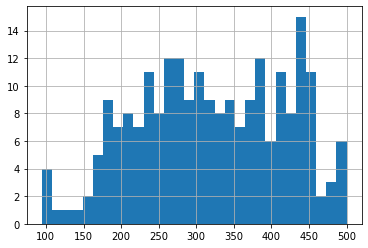

In [48]:
kitharai[kitharai['kithara_width'] <= 500].kithara_width.hist(bins = 30);

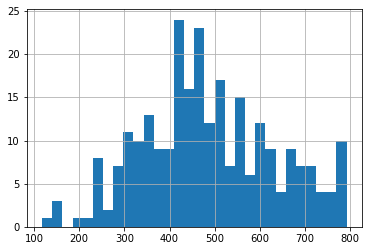

In [47]:
kitharai[kitharai['kithara_height'] <= 800].kithara_height.hist(bins = 30);

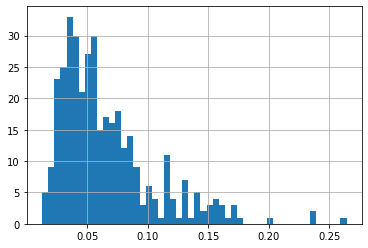

In [50]:
kitharai.width_proportion.hist(bins = 50);

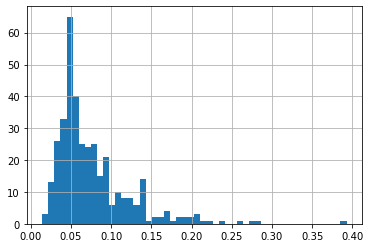

In [51]:
kitharai.height_proportion.hist(bins = 50);

In [54]:
kitharai.height_proportion.describe()

count    368.000000
mean       0.076610
std        0.047511
min        0.014323
25%        0.047212
50%        0.061202
75%        0.093640
max        0.392708
Name: height_proportion, dtype: float64

In [69]:
kitharai.width_proportion.describe()

count    368.000000
mean       0.065725
std        0.039636
min        0.012891
25%        0.037402
50%        0.055143
75%        0.081055
max        0.264062
Name: width_proportion, dtype: float64

In [64]:
_, hbins10 = pd.qcut(kitharai['height_proportion'], q = 10, retbins = True)

In [65]:
print(hbins10)

[0.01432292 0.03386193 0.04420737 0.04878881 0.05326455 0.06120242
 0.07270833 0.08455025 0.10388565 0.13705848 0.39270833]


In [67]:
_, wbins10 = pd.qcut(kitharai['width_proportion'], q = 10, retbins = True)

In [68]:
print(wbins10)

[0.01289062 0.02795573 0.034375   0.04010417 0.04828125 0.05514323
 0.06416667 0.07471354 0.08765625 0.11984522 0.2640625 ]


*Based on the quartile and decile breakdowns of kithara `width_proportion` and `height_proportion`, the %s used will be:*
* 10th %ile h: 3.4%, w: 2.8%, average: 3.1%
* 25th %ile h: 4.7%, w: 3.7%, average: 4.2%
* 50th %ile h: 6.1%, w: 5.5%, average: 5.8%
* 75th %ile h: 9.4%, w: 8.1%, average: 8.8%
* 90th %ile h: 13.7%, w: 12%, average: 12.9%

#### Define `multiply_image` function

*Scan over the image, from top left, and chop it into multiple equal-sized squares based on the %ile size. Save only square boxes (i.e. remove remainders).*

In [73]:
# for each image in the folder
# get the height and width of each image
# iterate over the image and create pixel squares the same size
# write cropped images out to separate folders

def multiply_image(name):
    # read in the image
    img = cv2.imread("../data/test/{}.jpg".format(name))
    # get the size of the image
    y_max, x_max, _ = img.shape
    # calculate %ile sizes
    y_size10 = int(y_max * 0.034375)
    y_size25 = int(y_max * 0.047212)
    y_size50 = int(y_max * 0.061202)
    y_size75 = int(y_max * 0.093640)
    y_size90 = int(y_max * 0.13705848)
    x_size10 = int(x_max * 0.02795573)
    x_size25 = int(x_max * 0.037402)
    x_size50 = int(x_max * 0.05514323)
    x_size75 = int(x_max * 0.081055)
    x_size90 = int(x_max * 0.11984522)
    # set the image size based on the larger of x or y
    size10 = np.where(x_size10 > y_size10, x_size10, y_size10).item(0)
    size25 = np.where(x_size25 > y_size25, x_size25, y_size25).item(0)
    size50 = np.where(x_size50 > y_size50, x_size50, y_size50).item(0)
    size75 = np.where(x_size75 > y_size75, x_size75, y_size75).item(0)
    size90 = np.where(x_size90 > y_size90, x_size90, y_size90).item(0)
    # set variable with sizes
    sizes = [size10, size25, size50, size75, size90]
    for size in sizes:
        # set the increment to 1/2 the size of the larger of x or y length for the kithara
        inc = int(size/2)
        # incrementally move forward, starting at the top L corner, by 1/2 the largest dimension of the kithara size
        # get a bunch of square images that are the size of the kithara (or smaller, if running into an edge)
        for y in range(0, y_max, inc):
            if y + size <= y_max:
                start_y = y
                end_y = y + size
            else:
                start_y = y
                end_y = y_max            
            for x in range(0, x_max, inc):
                if x + size <= x_max:
                    start_x = x
                    end_x = x + size
                else:
                    start_x = x
                    end_x = x_max
                # create the cropped image based on the coordinates set above
                cropped_img = img[start_y:end_y, start_x:end_x]
                if (end_y - start_y) == (end_x - start_x):
                    cv2.imwrite("../data/test/processed/{}-{}-{}-{}.jpg".format(name, size, start_y, start_x), cropped_img)

#### Run the function over the original image data

In [74]:
# run the functions over the image folder    
for path in glob.glob("../data/test/*.jpg"):
    name = os.path.splitext(os.path.basename(path))[0]
    multiply_image(name)

#### Define `image_scaler` function

*Rescale the images to the median size of a kithara (558 x 558 pixels).*

In [11]:
def image_scaler(folder, name):
    img = cv2.imread("../data/images-cropped/{}/{}.jpg".format(folder, name))
    # create a variable to tell the function how much to scale the original up/down to 558x558 pixesl
    scale_percent = 558 / (img.shape[0])
    # create new dimensions tuple
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite("../data/images-cropped/{}-resized/{}.jpg".format(folder, name), img)

In [12]:
# run the functions over the three subfolders in the cropped images folder
for folder in ['kithara-full', 'kithara-partial', 'no-kithara']:
    for path in glob.glob("../data/images-cropped/"+folder+"/*.jpg"):
        name = os.path.splitext(os.path.basename(path))[0]
        image_scaler(folder, name)

### Next Steps
* ~~Tag images that intersect the boxes with the kithara in it~~
* ~~Get rid of incorrectly-sized images~~
* ~~Resize all images~~
* ~~Test on a larger dataset~~
* Refactor the functions above to prevent unnecessary duplication of work

### Use AWS to process images
* ~~Put images in an S3 bucket~~
* ~~Use lambda to process~~ <-- ended up using another computer to process the images
* ~~Put the standardized and resized images into another S3 bucket~~

### Split the images into train / test groups
* ~~Generate list of the image names in each folder~~
* ~~Split the lists into train / test groups~~
* ~~Organize the images into folders based on train / test split to set up for keras CNN~~ <-- see notebook 02

### Train a model
* ~~Using the keras `Inceptionv3` base, train a model to identify kitharai~~ <-- see notebook 03

### Refactoring WIP

*The following lines are a WIP to refactor the functions to run one to get the kithara metadata separately, as well as to optimize the image resizing function. Commented out for now while working on the rest of the project.*

In [13]:
# This is the kithara metadata function
# # create a function to get the coordinates of the kithara
# def kithara_metadata(name):
#     kithara = pd.read_csv('../data/coordinates/{}.csv'.format(name)).iloc[:, 1:]
#     kx_min = kithara.x_top_left.values[0]
#     kx_max = kithara.x_bottom_right.values[0]
#     ky_min = kithara.y_top_left.values[0]
#     ky_max = kithara.y_bottom_right.values[0]
#     kx_size = kx_max - kx_min
#     ky_size = ky_max - ky_min
#     # set the image size based on the larger of x or y for the kithara
#     k_max = np.where(kx_size > ky_size, kx_size, ky_size).item(0)
#     # set the increment to 1/2 the size of the larger of x or y for the kithara
#     k_inc = int(k_max/2)
#     return {'kx_min': int(kx_min),
#             'kx_max': int(kx_max),
#             'ky_min': int(ky_min),
#             'ky_max': int(ky_max),
#             'kx_size': int(kx_size),
#             'ky_size': int(ky_size),
#             'k_max': int(k_max),
#             'k_inc': int(k_inc)}

In [14]:
# print(type(kithara_metadata('IMAG0009').get('kx_min')))

In [15]:
# kithara_metadata('IMAG0009')

In [16]:
# # for each image in the folder
# # get the height and width of each image
# # then iterate over the image and create 1000 x 1000 pixel squares
# def multiply_image(name):
#     # read in the image
#     img = cv2.imread("../data/test/{}.jpg".format(name))
#     # get the size of the image
#     y_max, x_max, _ = img.shape  
#     # get the coordinates of the kithara
#     k = kithara_metadata(name)
#     # incrementally move forward, starting at the top L corner, by 1/2 the largest dimension of the kithara size
#     # get a bunch of square images that are the size of the kithara
#     for y in range(0, int(k.get('y_max')), int(k.get('k_inc'))):
#         start_y = y
#         end_y = y + int(k.get('k_max'))
#         for x in range(0, int(k.get('x_max')), int(k.get('k_inc'))):
#             start_x = x
#             end_x = x + int(k.get('k_max'))
#             # set the image coordinates
#             cropped_img = img[start_y:end_y, start_x:end_x]
#             # crop the image
#             cv2.imwrite("../data/cropped_images/{}-{}-{}.png".format(name, y, x), cropped_img)

In [17]:
# # run the functions over the cropped images folder    
# for path in glob.glob("../data/images-cropped/*/"):
#     folder = os.path.splitext(os.path.dirname(path))[0].split("/images-cropped/")[1]
#     for path in glob.glob("../data/images-cropped/"+folder+"/*.jpg"):
#         name = os.path.splitext(os.path.basename(path))[0]
#         image_scaler(name)